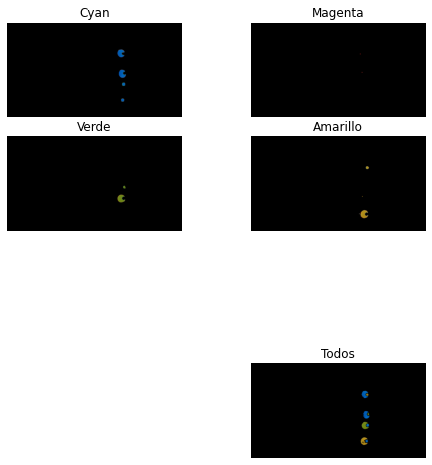

[42.0, 4565.5, 42.0, 760.5]


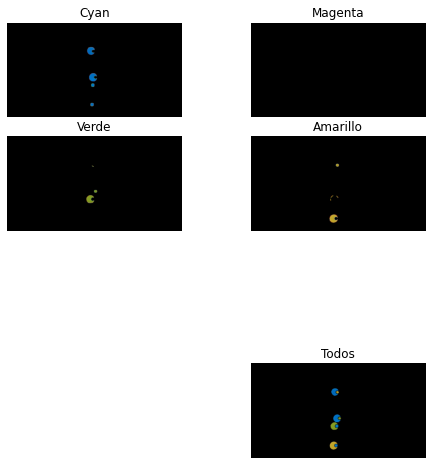

[5360.0, 128.0, 209.0, 229.5, 861.5]


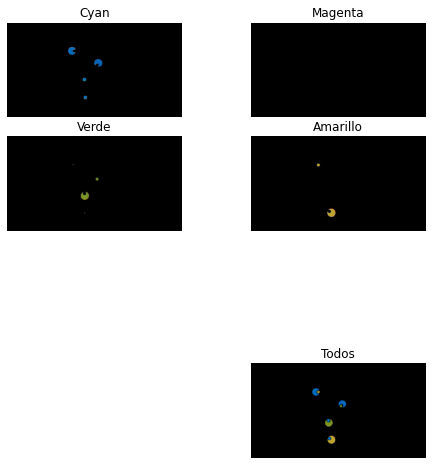

[5215.5, 826.5]


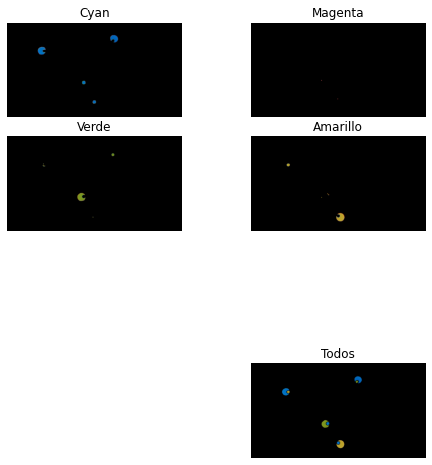

[5228.5, 42.0, 82.5, 59.0, 800.0]


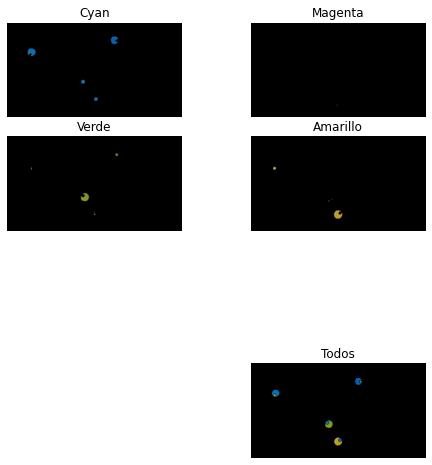

[5280.0, 78.0, 36.0, 742.5]


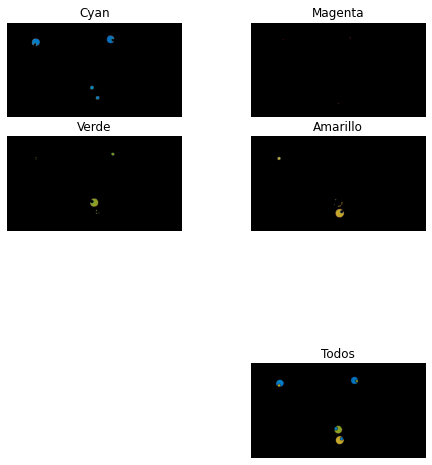

[5365.0, 241.0, 36.0, 230.5, 76.5, 816.5]


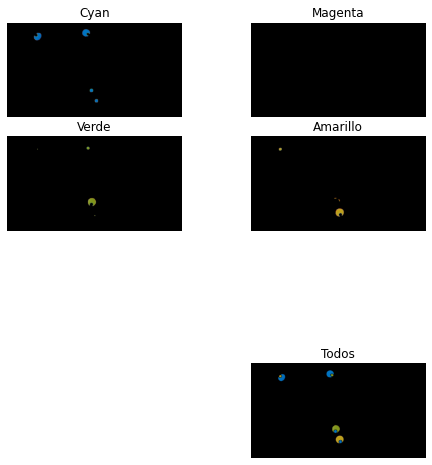

[5063.5, 186.0, 146.0, 719.5]


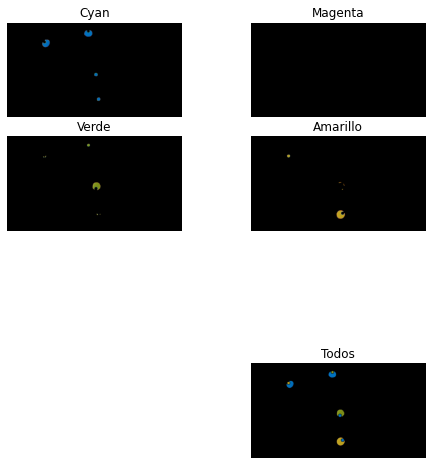

[5320.5, 79.0, 61.0, 42.0, 96.0, 48.5, 764.0]


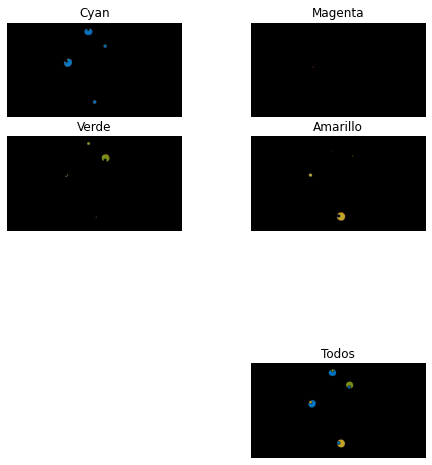

[5230.0, 888.0, 79.0, 36.0]


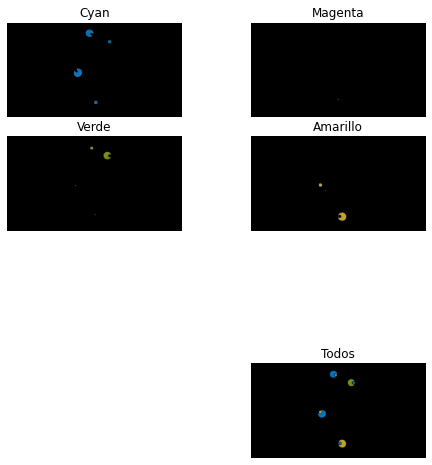

[5247.5, 42.0, 984.5]


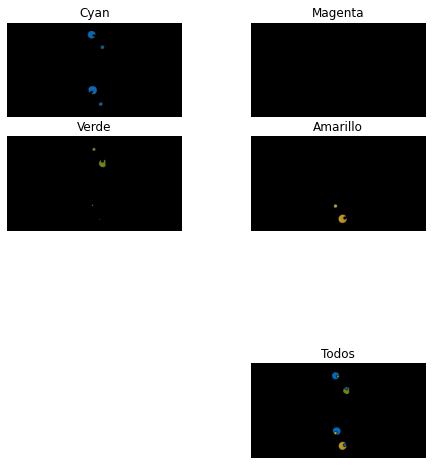

[5152.5, 900.0]


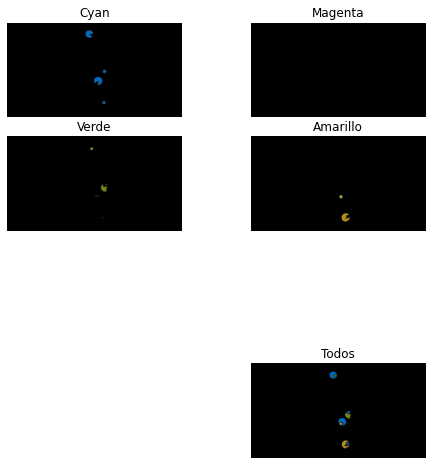

[4909.5, 82.5, 877.0]


In [28]:
#Bibliotecas requeridas
import cv2
import cv2 as cv
import glob
import re
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import os

def depurar_contornos(cnts):
    #en esta lista se almacenarán los contornos pertenecientes a los círculos
    #la "d" significa depurados.
    cntsd= []
    #recorro todos los contornos encontrados
    for cnt in cnts:
        area= cv2.contourArea(cnt)
        cntsd.append(area)    
    return cntsd

def obtenerFrames(nombreVideoIn, nombreCarpetaOut):
    #Se extraen los cuadros del video y se guardan
    #El vídeo está en 30 fps
    
    cap= cv2.VideoCapture(nombreVideoIn)
    n=0
    contFrames=0
    contImagenes=0
    #cada cuántos frames guardo una imagen
    espaciado=5  #aprox cada 10 segundos tomando en cuenta 30fps  #REBECA
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        #este
        if contFrames==espaciado:
            cv2.imwrite(str(nombreCarpetaOut)+'/frame'+str(contImagenes)+'.jpg',frame)
            contImagenes+=1
            contFrames=0
        n+=1
        contFrames+=1
    cap.release()
    cv2.destroyAllWindows()
    

    #Se cargan los cuadros del video en una colección
    #primero se guardan los nombres de las imagenes
    col_images = []
    col_frames = os.listdir(str(nombreCarpetaOut))

    # se ordenan por nombre, en este caso se guardaron con numeración consecutiva
    col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))
    #returna el número de frames de la imagen
    #con este número y la duración del vídeo se obtienen los fps
    return n

def findMax(cnts):
    maxN = cnts[0]
    for i in range(len(cnts)-1):
        if (cnts[i+1]>maxN):
            maxN = cnts[i+1]
            
    ind = cnts.index(maxN)
    cnts[ind] = 0
    maxN2 = cnts[0]
    for i in range(len(cnts)-1):
        if (cnts[i+1]>maxN2):
            maxN2 = cnts[i+1]
    
    return maxN, maxN2
    
#Dirección de imágenes para realizar el ajuste de áreas
nombreVideoIn = '2023-03-27_14-57-16_1fps.mp4'
nombreCarpetaOut = 'Imagenes_Ajuste_Areas/'

#Solo ejecutar esta línea una vez para cada video que se use
#numFrames = obtenerFrames(nombreVideoIn, nombreCarpetaOut)

dir = nombreCarpetaOut

#Guarda los nombres de las imágenes que estaban en la carpeta en la lista imgList
imgList = os.listdir(dir)
#Inicializa la lista que contendrá a las imágenes que se utilizarán
imagenes = []
imagenesHSV = []
#Ordena las imágenes por número de menor a mayor
imgList.sort (key = lambda x: int (x.replace ("frame", ""). split ('.') [0])) 
#Inicializa contadores
n = 0
cont = 0
ind = 0
#resolución espacial para imagen sin zoom [mm/pixel]
mmPixel=40/16

#Carga los matrices de calibración
mtx = np.loadtxt('cameraMatrix.txt', dtype=float)
#newcameramtx = np.loadtxt('newCameraMatrix.txt', dtype=float)
dist = np.loadtxt('dist.txt', dtype=float)
#roi = np.loadtxt('roi.txt', dtype=int)

for i in imgList:
    #va contando los frames, prevista para frames
    #cont+=1
    #Lee cada imagen, donde i es el nombre de cada una
    img_conDist = cv2.imread(nombreCarpetaOut+i)
    
    h,  w = img_conDist.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    
    #Prevista para cada cuantos frames se quiere trabajar
    """if cont == 4:
        imagenes.append(img)     
        cont = 0
        n+=1"""
    
    #Elimina distorsión
    dst = cv.undistort(img_conDist, mtx, dist, None, newcameramtx)
    
    # recorta la imagen
    x, y, w, h = roi
    #Imagen sin distorsión
    img = dst[y:y+h, x:x+w]            
    
    #Convirtiendo a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #Guarda las imágenes en RGB en una lista
    imagenes.append(img)
    
    #Guarda las imágenes en HSV en una lista
    imagenesHSV.append(hsv)
    #va contando las imágenes que hay
    n+=1


#--------------------- Definición de rangos de color HSV---------------------------
# Para modificar filtros, deben modificarse los últimos dos términos de cada línea

#Rangos cyan:
light_cyan = (95, 157, 145)
dark_cyan = (105, 255, 250) 

#Rangos rosado:
light_magenta = (135, 140, 190)
dark_magenta = (190, 240, 250)

#Rangos verde:  
light_verde = (30, 125, 125)
dark_verde = (40, 255, 255)

#Rangos azul: 
light_azul = (100,255,25)
dark_azul = (130,255,160)

#Rangos amarillo: 
light_ama = (13, 25, 175)
dark_ama = (30, 255, 255)

#Crea un respaldo de todas las imágenes para ser modificadas más adelante
RespaldoImagenes=list(imagenes)

#------------Procesado: aplicar máscara, dilatar, contornos, ubicación -----------------
#Aquí se almacenarán los contornos de cada una de las imágenes
lista_cCyan = []
lista_cMagenta = []
lista_cVerde = []
lista_cRojo = []
lista_cAzul = []
lista_cNaranja = []
lista_cAmarillo = []
#Aquí se almacenarán los centros de los contornos
centros_cCyan = []
centros_cMagenta = []
centros_cNaranja = []
centros_cAmarillo = []
centros_cVerde = []
centros_cRojo = []
centros_cAzul = []

for j in range(len(imagenes)):
    #Máscara Cyan
    #Pone 1 en el píxel que está dentro del rango, sino pone 0
    maskcyan = cv2.inRange(imagenesHSV[j], light_cyan, dark_cyan)
    #Máscara Magenta
    maskmagenta = cv2.inRange(imagenesHSV[j], light_magenta, dark_magenta)
    #Máscara Verde
    maskverde = cv2.inRange(imagenesHSV[j], light_verde, dark_verde)
    #Máscara Amarilla
    maskama = cv2.inRange(imagenesHSV[j], light_ama, dark_ama)
    #Máscara Naranja
    masknar = cv2.inRange(imagenesHSV[j], light_nar, dark_nar)
    #Máscara Azul
    maskazul = cv2.inRange(imagenesHSV[j], light_azul, dark_azul)
    #Máscara Rojo
    maskrojo = cv2.inRange(imagenesHSV[j], light_rojo, dark_rojo)
    
    #Máscara de todos los colores de identificadores:
    maskAll=maskrojo+maskazul+maskama+maskcyan+maskverde+maskmagenta+masknar

    #Se utiliza una transformación morfológica de dilatación de la imagen para hacer los
    #contornos más uniformes
    #Se crea el kernel, entre mayor sea más "grosera" es la dilatación
    kernel = np.ones((7,7),np.uint8)
    cyand = cv2.dilate(maskcyan,kernel,iterations=1)
    magentad = cv2.dilate(maskmagenta,kernel,iterations=1)
    verded = cv2.dilate(maskverde,kernel,iterations=1)
    amarillod = cv2.dilate(maskama,kernel,iterations=1)
    naranjad = cv2.dilate(masknar,kernel,iterations=1)
    azuld = cv2.dilate(maskazul,kernel,iterations=1)
    rojod = cv2.dilate(maskrojo,kernel,iterations=1)
    alld = cyand+magentad+verded+amarillod+naranjad+azuld+rojod
    
    #Aplica las máscaras a las imágenes por si se quisieran visualizar
    #"""
    resultcyan = cv2.bitwise_and(imagenes[j], imagenes[j], mask=cyand)
    resultmagenta = cv2.bitwise_and(imagenes[j], imagenes[j], mask=magentad)
    resultverde = cv2.bitwise_and(imagenes[j], imagenes[j], mask=verded)
    resultama = cv2.bitwise_and(imagenes[j], imagenes[j], mask=amarillod)
    resultnar = cv2.bitwise_and(imagenes[j], imagenes[j], mask=naranjad)
    resultazul = cv2.bitwise_and(imagenes[j], imagenes[j], mask=azuld)
    resultrojo = cv2.bitwise_and(imagenes[j], imagenes[j], mask=rojod)
    #Aplica la máscara combinada
    resultAll = cv2.bitwise_and(imagenes[j], imagenes[j], mask=maskAll)
    
    
    #Muestra los resultados de filtrado por color para una imagen
    
    #Utilizar las siguientes líneas abajo de cada plt.title(" ") si se desea ir guardando 
    #cada imagen en la carpeta del código:
    
    #title = 'filtrado_naranga'+str(ind)+'.png'
    #cv.imwrite(title, resultnar)
    
    
    #"""
    # ind es el numero de frames que va a generar
    if ind >= 0:
        # se crea la figura
        fig = plt.figure(figsize=(8, 8))
        # definición de filas y columnas
        rows = 4
        columns = 2
        
        # Agrega un subplot en la primera posición
        fig.add_subplot(rows, columns, 1)
        # mostrando la imagen
        plt.imshow(resultcyan)
        plt.axis('off')
        plt.title("Cyan")
        #title = 'filtrado_cyan'+str(ind)+'.png'
        #cv.imwrite(title, resultcyan)
        
        # segunda posición
        # Las últimas dos lineas generan las imágenes del color filtrado
        # se comentan o descomentan según el color que se quiera calibrar
        fig.add_subplot(rows, columns, 2)
        plt.imshow(resultmagenta)
        plt.axis('off')
        plt.title("Magenta")
        #title = 'filtrado_rosa'+str(ind)+'.png'
        #cv.imwrite(title, resultmagenta)
        
        # tercera posición
        fig.add_subplot(rows, columns, 3)
        plt.imshow(resultverde)
        plt.axis('off')
        plt.title("Verde")
        #title = 'filtrado_verde'+str(ind)+'.png'
        #cv.imwrite(title, resultverde)
        
        # cuarta posición
        fig.add_subplot(rows, columns, 4)
        plt.imshow(resultama)
        plt.axis('off')
        plt.title("Amarillo")
        #title = 'filtrado_ama'+str(ind)+'.png'
        #cv.imwrite(title, resultama)
        
        # octava posición
        fig.add_subplot(rows, columns, 8)
        plt.imshow(resultAll)
        plt.axis('off')
        plt.title("Todos")
        plt.show()
        #title = 'filtrado_todos'+str(ind)+'.png'
        #cv.imwrite(title, resultAll)
    
    ind+=1
    #"""
    
    #se inicializa la variable de tamaño de contorno
    sizeC=0
    #Busca los contornos en cada una de las imágenes filtradas
    #Se aproximan por medio de una compresión horizontal, vertical y diagonal
    #https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0
    cntsCyan, jerCyan = cv2.findContours(cyand.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsMagenta, jerMagenta = cv2.findContours(magentad.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsAmarillo, jerAmarillo = cv2.findContours(amarillod.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    cntsNaranja, jerNaranja = cv2.findContours(naranjad.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsRojo, jerRojo = cv2.findContours(rojod.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    cntsVerde, jerVerde = cv2.findContours(verded.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cntsAzul, jerAzul = cv2.findContours(azuld.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   
    
    #Deja solo los contornos grandes, correspondientes a los círculos pequeños y grandes
    cntsCyans=depurar_contornos(cntsCyan)
    cntsMagentas=depurar_contornos(cntsMagenta)
    cntsVerdes=depurar_contornos(cntsVerde)
    
    cntsAmarillos=depurar_contornos(cntsAmarillo) #Lo agregó Sharon
    
    cntsAzules=depurar_contornos(cntsAzul)
    cntsNaranjas=depurar_contornos(cntsNaranja)
    cntsRojos=depurar_contornos(cntsRojo)
    
    print(cntsAmarillos) #Dificilmente detectables por iluminación
    
    #print(cntsVerdes)

    #print(cntsCyans)
    
    #print(cntsMagentas)
    
    #print(cntsAzules)

    
#Link de ayuda para ajustar valores HSV:https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv